In [1]:
import gym
import pylab
import random
import numpy as np
from collections import deque
import tflearn

import tflearn
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.optimizers import Adam

/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
Using TensorFlow backend.


## Task: fill empty spaces in the following agent code

In [2]:
class DeepQAgent:
    def __init__(self, state_size, action_size, render=True):
        # Tip: if you are training this on AWS the best way is to turn off rendering
        # and load it later with the serialized model
        self.render = render
        self.state_size = state_size
        self.action_size = action_size

        self.discount_factor = 0.99
        self.learning_rate = 0.001
        self.epsilon = 1.0
        self.epsilon_min = 0.005
        self.epsilon_decay = (self.epsilon - self.epsilon_min) / 50000
        self.batch_size = 64
        self.train_start = 1000
        # replay memory
        self.memory = deque(maxlen=10000)

        self.model = self.build_model()
        self.target_model = self.build_model()
        self.update_target_model()

    def build_model(self):
        model = Sequential()
        model.add(Dense(64, input_dim = self.state_size))
        model.add(Activation('relu'))
        model.add(Dense(64))
        model.add(Activation('relu'))
        model.add(Dense(32))
        model.add(Activation('relu'))
        model.add(Dense(self.action_size))
        model.add(Activation('linear'))
        model.compile(Adam(lr=self.learning_rate), "mse")
        return model

    def update_target_model(self):
        """Update your target model to the model you are currently learning at regular time intervals"""
        self.target_model.set_weights(self.model.get_weights())

    def get_action(self, state):
        """The choice of action uses the epsilon-greedy policy for the current network."""
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        else:
            q_value = self.model.predict(state)
            return np.argmax(q_value[0])

    def replay_memory(self, state, action, reward, next_state, done):
        """Save <s, a, r, s'> to replay_memory"""
        if action == 2:
            action = 1
        self.memory.append((state, action, reward, next_state, done))
        if self.epsilon > self.epsilon_min:
            self.epsilon -= self.epsilon_decay
            # print(len(self.memory))

    def train_replay(self):
        """Random sampling of batch_size samples from replay memory"""
        if len(self.memory) < self.train_start:
            return
        batch_size = min(self.batch_size, len(self.memory))
        mini_batch = random.sample(self.memory, batch_size)

        update_input = np.zeros((batch_size, self.state_size))
        update_target = np.zeros((batch_size, self.action_size))

        for i in range(batch_size):
            state, action, reward, next_state, done = mini_batch[i]
            target = self.model.predict(state)[0]

            # As in queuing, it gets the maximum Q Value at s'. However, it is imported from the target model.
            if done:
                target[action] = reward
            else:
                target[action] = reward + self.discount_factor * \
                                          np.amax(self.target_model.predict(next_state)[0])
            update_input[i] = state
            update_target[i] = target

        # You can create a minibatch of the correct target answer and the current value of your own,
        self.model.fit(update_input, update_target, batch_size=batch_size, epochs=1, verbose=0)

    def load_model(self, name):
        self.model.load_model(name)

    def save_model(self, name):
        self.model.save(name)


In [3]:
env = gym.make('MountainCar-v0')
state_size = env.observation_space.shape[0] # should be equal 2
ACTION_SIZE = 2
agent = DeepQAgent(state_size, ACTION_SIZE)
# agent.load_model("./save_model/<your_saved_model_name>")
scores, episodes = [], []
N_EPISODES = 2000

In [4]:
for e in range(N_EPISODES):
    done = False
    score = 0
    state = env.reset()
    state = np.reshape(state, [1, state_size])
    print(state)

    # Action 0 (left), 1 (do nothing), 3 (declare fake_action to avoid doing nothing
    fake_action = 0

    # Counter for the same action 4 times
    action_count = 0

    while not done:
        if agent.render:
            env.render()

        # Select an action in the current state and proceed to a step
        action_count = action_count + 1

        if action_count == 4:
            action = agent.get_action(state)
            action_count = 0

            if action == 0:
                fake_action = 0
            elif action == 1:
                fake_action = 2

        # Take 1 step with the selected action
        next_state, reward, done, info = env.step(fake_action)
        next_state = np.reshape(next_state, [1, state_size])
        # Give a penalty of -100 for actions that end an episode
        # reward = reward if not done else -100

        # Save <s, a, r, s'> to replay memory
        agent.replay_memory(state, fake_action, reward, next_state, done)
        # Continue to learn every time step
        agent.train_replay()
        score += reward
        state = next_state

        if done:
            env.reset()
            # Copy the learning model for each episode to the target model
            agent.update_target_model()

            # For each episode, the time step where cartpole stood is plot
            scores.append(score)
            episodes.append(e)
            print("episode:", e, "  score:", score, "  memory length:", len(agent.memory),
                  "  epsilon:", agent.epsilon)

    # Save model for every 50 episodes
    if e % 50 == 0:
        agent.save_model("./save_model/saved_model_2")

[[-0.51833912  0.        ]]
episode: 0   score: -200.0   memory length: 200   epsilon: 0.9960200000000077
[[-0.42409296  0.        ]]
episode: 1   score: -200.0   memory length: 400   epsilon: 0.9920400000000154
[[-0.55066996  0.        ]]
episode: 2   score: -200.0   memory length: 600   epsilon: 0.988060000000023
[[-0.55838337  0.        ]]
episode: 3   score: -200.0   memory length: 800   epsilon: 0.9840800000000307
[[-0.56326893  0.        ]]
episode: 4   score: -200.0   memory length: 1000   epsilon: 0.9801000000000384
[[-0.46811479  0.        ]]
episode: 5   score: -200.0   memory length: 1200   epsilon: 0.9761200000000461
[[-0.40051446  0.        ]]
episode: 6   score: -200.0   memory length: 1400   epsilon: 0.9721400000000537
[[-0.48468296  0.        ]]
episode: 7   score: -200.0   memory length: 1600   epsilon: 0.9681600000000614
[[-0.4961765  0.       ]]
episode: 8   score: -200.0   memory length: 1800   epsilon: 0.9641800000000691
[[-0.52185165  0.        ]]
episode: 9   sco

episode: 76   score: -200.0   memory length: 10000   epsilon: 0.6935400000005911
[[-0.5550478  0.       ]]
episode: 77   score: -200.0   memory length: 10000   epsilon: 0.6895600000005988
[[-0.44399213  0.        ]]
episode: 78   score: -200.0   memory length: 10000   epsilon: 0.6855800000006065
[[-0.4008819  0.       ]]
episode: 79   score: -200.0   memory length: 10000   epsilon: 0.6816000000006142
[[-0.59017773  0.        ]]
episode: 80   score: -200.0   memory length: 10000   epsilon: 0.6776200000006218
[[-0.46597995  0.        ]]
episode: 81   score: -200.0   memory length: 10000   epsilon: 0.6736400000006295
[[-0.58889442  0.        ]]
episode: 82   score: -200.0   memory length: 10000   epsilon: 0.6696600000006372
[[-0.41603386  0.        ]]
episode: 83   score: -200.0   memory length: 10000   epsilon: 0.6656800000006449
[[-0.56047885  0.        ]]
episode: 84   score: -200.0   memory length: 10000   epsilon: 0.6617000000006525
[[-0.50146811  0.        ]]
episode: 85   score: -2

episode: 151   score: -200.0   memory length: 10000   epsilon: 0.40799490000088523
[[-0.57399651  0.        ]]
episode: 152   score: -129.0   memory length: 10000   epsilon: 0.405427800000883
[[-0.52222139  0.        ]]
episode: 153   score: -184.0   memory length: 10000   epsilon: 0.40176620000087987
[[-0.49041405  0.        ]]
episode: 154   score: -200.0   memory length: 10000   epsilon: 0.39778620000087644
[[-0.45173567  0.        ]]
episode: 155   score: -158.0   memory length: 10000   epsilon: 0.39464200000087374
[[-0.47915572  0.        ]]
episode: 156   score: -150.0   memory length: 10000   epsilon: 0.39165700000087117
[[-0.53852342  0.        ]]
episode: 157   score: -200.0   memory length: 10000   epsilon: 0.38767700000086774
[[-0.58249377  0.        ]]
episode: 158   score: -114.0   memory length: 10000   epsilon: 0.3854084000008658
[[-0.5561007  0.       ]]
episode: 159   score: -127.0   memory length: 10000   epsilon: 0.3828811000008636
[[-0.406094  0.      ]]
episode: 16

episode: 226   score: -120.0   memory length: 10000   epsilon: 0.18187120000078566
[[-0.55066639  0.        ]]
episode: 227   score: -137.0   memory length: 10000   epsilon: 0.17914490000078712
[[-0.52041833  0.        ]]
episode: 228   score: -137.0   memory length: 10000   epsilon: 0.17641860000078857
[[-0.5924666  0.       ]]
episode: 229   score: -117.0   memory length: 10000   epsilon: 0.17409030000078982
[[-0.46529222  0.        ]]
episode: 230   score: -149.0   memory length: 10000   epsilon: 0.1711252000007914
[[-0.48782373  0.        ]]
episode: 231   score: -155.0   memory length: 10000   epsilon: 0.16804070000079305
[[-0.59351402  0.        ]]
episode: 232   score: -132.0   memory length: 10000   epsilon: 0.16541390000079445
[[-0.42941294  0.        ]]
episode: 233   score: -88.0   memory length: 10000   epsilon: 0.16366270000079539
[[-0.41845579  0.        ]]
episode: 234   score: -167.0   memory length: 10000   epsilon: 0.16033940000079716
[[-0.56787453  0.        ]]
episo

episode: 301   score: -98.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.51909756  0.        ]]
episode: 302   score: -125.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.44687603  0.        ]]
episode: 303   score: -125.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.55666984  0.        ]]
episode: 304   score: -125.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.50244936  0.        ]]
episode: 305   score: -128.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.55614758  0.        ]]
episode: 306   score: -123.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.43843203  0.        ]]
episode: 307   score: -125.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.41434219  0.        ]]
episode: 308   score: -140.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.46428496  0.        ]]
episode: 309   score: -96.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.57958549  0.     

episode: 375   score: -116.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.44950371  0.        ]]
episode: 376   score: -91.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.46281099  0.        ]]
episode: 377   score: -95.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.58117011  0.        ]]
episode: 378   score: -116.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.56753025  0.        ]]
episode: 379   score: -116.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.52991841  0.        ]]
episode: 380   score: -117.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.53157395  0.        ]]
episode: 381   score: -112.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.48839201  0.        ]]
episode: 382   score: -113.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.59320941  0.        ]]
episode: 383   score: -113.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.57715485  0.     

episode: 449   score: -109.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.50416951  0.        ]]
episode: 450   score: -165.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.57692521  0.        ]]
episode: 451   score: -108.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.55016746  0.        ]]
episode: 452   score: -108.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.50493087  0.        ]]
episode: 453   score: -149.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.44112614  0.        ]]
episode: 454   score: -89.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.51395932  0.        ]]
episode: 455   score: -151.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.4220572  0.       ]]
episode: 456   score: -85.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.47400568  0.        ]]
episode: 457   score: -101.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.52114431  0.       

episode: 523   score: -181.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.49703371  0.        ]]
episode: 524   score: -162.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.5466369  0.       ]]
episode: 525   score: -116.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.51648439  0.        ]]
episode: 526   score: -109.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.51519472  0.        ]]
episode: 527   score: -110.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.48477489  0.        ]]
episode: 528   score: -168.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.49590358  0.        ]]
episode: 529   score: -111.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.4300511  0.       ]]
episode: 530   score: -87.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.43157386  0.        ]]
episode: 531   score: -88.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.46816221  0.        ]

episode: 597   score: -86.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.58103082  0.        ]]
episode: 598   score: -108.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.51565154  0.        ]]
episode: 599   score: -109.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.5892404  0.       ]]
episode: 600   score: -109.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.40568362  0.        ]]
episode: 601   score: -84.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.47245112  0.        ]]
episode: 602   score: -111.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.59368242  0.        ]]
episode: 603   score: -119.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.42872909  0.        ]]
episode: 604   score: -86.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.45564779  0.        ]]
episode: 605   score: -93.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.55194495  0.        ]

episode: 671   score: -111.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.51515835  0.        ]]
episode: 672   score: -111.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.56380267  0.        ]]
episode: 673   score: -112.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.55807058  0.        ]]
episode: 674   score: -112.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.5325195  0.       ]]
episode: 675   score: -114.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.4041959  0.       ]]
episode: 676   score: -83.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.52883296  0.        ]]
episode: 677   score: -111.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.43882813  0.        ]]
episode: 678   score: -89.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.50561589  0.        ]]
episode: 679   score: -110.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.57537548  0.        ]

episode: 745   score: -114.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.55002644  0.        ]]
episode: 746   score: -113.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.46426577  0.        ]]
episode: 747   score: -96.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.48428147  0.        ]]
episode: 748   score: -112.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.52225369  0.        ]]
episode: 749   score: -111.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.58256103  0.        ]]
episode: 750   score: -114.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.41246573  0.        ]]
episode: 751   score: -86.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.46136951  0.        ]]
episode: 752   score: -95.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.42005506  0.        ]]
episode: 753   score: -87.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.52181515  0.       

episode: 819   score: -110.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.50133041  0.        ]]
episode: 820   score: -110.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.43967867  0.        ]]
episode: 821   score: -88.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.46016165  0.        ]]
episode: 822   score: -175.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.52584125  0.        ]]
episode: 823   score: -113.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.53912805  0.        ]]
episode: 824   score: -110.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.57824959  0.        ]]
episode: 825   score: -110.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.48014956  0.        ]]
episode: 826   score: -113.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.50340337  0.        ]]
episode: 827   score: -111.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.55367292  0.    

episode: 893   score: -113.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.51172468  0.        ]]
episode: 894   score: -159.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.44701522  0.        ]]
episode: 895   score: -94.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.5820362  0.       ]]
episode: 896   score: -118.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.55207983  0.        ]]
episode: 897   score: -120.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.5793085  0.       ]]
episode: 898   score: -115.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.40979733  0.        ]]
episode: 899   score: -92.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.50278946  0.        ]]
episode: 900   score: -113.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.57250058  0.        ]]
episode: 901   score: -115.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.43376153  0.        ]

episode: 967   score: -115.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.58646021  0.        ]]
episode: 968   score: -116.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.5901519  0.       ]]
episode: 969   score: -116.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.43911144  0.        ]]
episode: 970   score: -89.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.56412975  0.        ]]
episode: 971   score: -110.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.56344187  0.        ]]
episode: 972   score: -110.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.40212993  0.        ]]
episode: 973   score: -83.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.46212287  0.        ]]
episode: 974   score: -95.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.53923469  0.        ]]
episode: 975   score: -118.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.55300675  0.        

episode: 1041   score: -126.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.44465151  0.        ]]
episode: 1042   score: -90.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.45923659  0.        ]]
episode: 1043   score: -94.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.53453543  0.        ]]
episode: 1044   score: -117.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.47791353  0.        ]]
episode: 1045   score: -108.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.53286921  0.        ]]
episode: 1046   score: -117.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.42251082  0.        ]]
episode: 1047   score: -95.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.5722375  0.       ]]
episode: 1048   score: -116.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.49459887  0.        ]]
episode: 1049   score: -172.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.5229957  0.

episode: 1114   score: -179.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.54733212  0.        ]]
episode: 1115   score: -121.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.48947026  0.        ]]
episode: 1116   score: -147.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.5124812  0.       ]]
episode: 1117   score: -151.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.5571075  0.       ]]
episode: 1118   score: -110.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.49105024  0.        ]]
episode: 1119   score: -172.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.47638924  0.        ]]
episode: 1120   score: -106.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.5174525  0.       ]]
episode: 1121   score: -151.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.43030858  0.        ]]
episode: 1122   score: -88.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.47856225  0. 

episode: 1187   score: -113.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.47847172  0.        ]]
episode: 1188   score: -105.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.43497412  0.        ]]
episode: 1189   score: -89.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.46330299  0.        ]]
episode: 1190   score: -96.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.52879389  0.        ]]
episode: 1191   score: -118.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.507486  0.      ]]
episode: 1192   score: -121.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.59783826  0.        ]]
episode: 1193   score: -117.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.53655687  0.        ]]
episode: 1194   score: -110.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.55628649  0.        ]]
episode: 1195   score: -110.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.48567061  0.

episode: 1260   score: -120.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.5127544  0.       ]]
episode: 1261   score: -115.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.47170399  0.        ]]
episode: 1262   score: -113.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.53444224  0.        ]]
episode: 1263   score: -119.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.56291785  0.        ]]
episode: 1264   score: -110.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.51562185  0.        ]]
episode: 1265   score: -112.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.4059182  0.       ]]
episode: 1266   score: -84.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.5074856  0.       ]]
episode: 1267   score: -127.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.49200716  0.        ]]
episode: 1268   score: -119.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.52483385  0. 

episode: 1333   score: -126.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.59891857  0.        ]]
episode: 1334   score: -110.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.5571667  0.       ]]
episode: 1335   score: -119.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.54095486  0.        ]]
episode: 1336   score: -110.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.50251075  0.        ]]
episode: 1337   score: -147.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.51543598  0.        ]]
episode: 1338   score: -134.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.44287712  0.        ]]
episode: 1339   score: -121.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.54966564  0.        ]]
episode: 1340   score: -121.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.43103732  0.        ]]
episode: 1341   score: -87.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.42424388 

episode: 1406   score: -114.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.43327961  0.        ]]
episode: 1407   score: -87.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.41956304  0.        ]]
episode: 1408   score: -85.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.41169531  0.        ]]
episode: 1409   score: -84.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.50269799  0.        ]]
episode: 1410   score: -151.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.41239738  0.        ]]
episode: 1411   score: -84.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.40329261  0.        ]]
episode: 1412   score: -83.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.48600233  0.        ]]
episode: 1413   score: -150.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.44134089  0.        ]]
episode: 1414   score: -94.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.55089124  0.

episode: 1479   score: -92.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.50255502  0.        ]]
episode: 1480   score: -111.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.41307069  0.        ]]
episode: 1481   score: -86.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.52238341  0.        ]]
episode: 1482   score: -111.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.43136468  0.        ]]
episode: 1483   score: -88.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.5781138  0.       ]]
episode: 1484   score: -110.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.54249196  0.        ]]
episode: 1485   score: -111.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.55863848  0.        ]]
episode: 1486   score: -118.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.57772642  0.        ]]
episode: 1487   score: -110.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.41645651  0

episode: 1552   score: -113.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.5341985  0.       ]]
episode: 1553   score: -113.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.41278714  0.        ]]
episode: 1554   score: -84.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.45655981  0.        ]]
episode: 1555   score: -93.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.58150874  0.        ]]
episode: 1556   score: -157.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.56234865  0.        ]]
episode: 1557   score: -109.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.42827351  0.        ]]
episode: 1558   score: -98.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.40811086  0.        ]]
episode: 1559   score: -84.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.50699851  0.        ]]
episode: 1560   score: -160.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.56346101  0.

episode: 1625   score: -85.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.52228332  0.        ]]
episode: 1626   score: -197.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.48270821  0.        ]]
episode: 1627   score: -122.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.50685034  0.        ]]
episode: 1628   score: -125.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.46065023  0.        ]]
episode: 1629   score: -99.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.41718461  0.        ]]
episode: 1630   score: -85.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.56176259  0.        ]]
episode: 1631   score: -110.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.47984161  0.        ]]
episode: 1632   score: -113.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.53925289  0.        ]]
episode: 1633   score: -110.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.40877197 

episode: 1698   score: -89.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.52331209  0.        ]]
episode: 1699   score: -111.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.56803953  0.        ]]
episode: 1700   score: -123.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.5432739  0.       ]]
episode: 1701   score: -116.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.40925782  0.        ]]
episode: 1702   score: -102.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.59635356  0.        ]]
episode: 1703   score: -115.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.48635564  0.        ]]
episode: 1704   score: -111.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.50720052  0.        ]]
episode: 1705   score: -111.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.49167467  0.        ]]
episode: 1706   score: -111.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.54319521 

episode: 1771   score: -113.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.56556741  0.        ]]
episode: 1772   score: -114.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.47091594  0.        ]]
episode: 1773   score: -105.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.42788169  0.        ]]
episode: 1774   score: -86.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.4047611  0.       ]]
episode: 1775   score: -83.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.47917517  0.        ]]
episode: 1776   score: -116.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.54965418  0.        ]]
episode: 1777   score: -120.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.57958329  0.        ]]
episode: 1778   score: -121.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.55348908  0.        ]]
episode: 1779   score: -122.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.57025014  

episode: 1844   score: -86.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.48351921  0.        ]]
episode: 1845   score: -158.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.57429561  0.        ]]
episode: 1846   score: -111.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.5894782  0.       ]]
episode: 1847   score: -108.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.5606163  0.       ]]
episode: 1848   score: -118.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.5197228  0.       ]]
episode: 1849   score: -122.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.50673576  0.        ]]
episode: 1850   score: -110.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.55622025  0.        ]]
episode: 1851   score: -116.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.46909683  0.        ]]
episode: 1852   score: -98.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.43631463  0.  

episode: 1917   score: -86.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.40998857  0.        ]]
episode: 1918   score: -84.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.434171  0.      ]]
episode: 1919   score: -87.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.43638958  0.        ]]
episode: 1920   score: -90.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.4048138  0.       ]]
episode: 1921   score: -84.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.56204838  0.        ]]
episode: 1922   score: -125.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.55801589  0.        ]]
episode: 1923   score: -127.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.51102937  0.        ]]
episode: 1924   score: -148.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.56268153  0.        ]]
episode: 1925   score: -122.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.59969373  0.     

episode: 1990   score: -109.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.50507105  0.        ]]
episode: 1991   score: -117.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.41628486  0.        ]]
episode: 1992   score: -85.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.49148197  0.        ]]
episode: 1993   score: -111.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.5026185  0.       ]]
episode: 1994   score: -110.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.56747988  0.        ]]
episode: 1995   score: -115.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.57425417  0.        ]]
episode: 1996   score: -117.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.44294097  0.        ]]
episode: 1997   score: -89.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.51490943  0.        ]]
episode: 1998   score: -127.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.58843792  

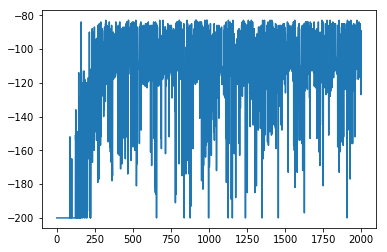

In [5]:
from matplotlib import pyplot as plt
plt.plot(scores)
plt.show()